#### PyNet: Building your own deep neural network with Numpy
##### Submission files:
- hw1.ipynb (with your completed code)
- PDF version of hw1.ipynb (with all results rendered)

##### Instructions:
- Complete the code below to train a deep neural network for binary classificaiton on a synthetic dataset.
- Design a deep neural network architecture for this binary classification task and achieve > 90% accuracy on test set.
- Note that to compute the backward pass, you might want to reuse some intermediate results from forward pass.

In [1101]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm

### Parameter Class 
##### A class storing the parameter values and gradients in a Layer. 

In [1102]:
class Parameter():
    """
    A class used to store parameters in a Layer.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    """
    def __init__(self, dim_shape):
        self.dim_shape = dim_shape
        self.val = np.zeros(dim_shape)
        self.grad = np.zeros_like(self.val)

### Layer Class 
##### An abstract class for all required computational modules in this assignment.

In [1103]:
class Layer():
    """
    An abstract class for all required computational modules.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients.
    """
    def __init__(self):
        pass

    def init_param(self):
        pass

    def forward(self):
        pass

    def backward(self):
        pass

    def parameters(self):
        pass

### (1) Linear Layer Class [10 points]
##### Instructions
- init_param
    - Use random initialization for the weights, e.g., np.random.randn()*0.1 with the correct shape.
    - Zero initialization for the biases.
- forward
    - Having initialized weight and bias, and given an input to the layer, compute the output of the layer.
- backward
    - Suppose you have an upstream gradient d_output = $\frac{\partial loss}{\partial output}$
    - Compute (d_input, d_weight, d_bias) using the chain rule.

In [1104]:
class Linear(Layer):
    """
    Linear layer.

    ...

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients of weight and bias for optimization.
    """
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.weight = Parameter((input_dim, output_dim))
        self.bias = Parameter((output_dim,))

        self.init_param()

    def init_param(self):
        self.weight.val = np.random.randn(self.input_dim, self.output_dim) * 0.1
        self.bias.val = np.random.randn(self.output_dim,) * 0

    def forward(self, input):
        self.input = input
        return (self.input @ self.weight.val) + self.bias.val 

    def backward(self, backward_input):
        #d_weight = x.T @ d_output
        self.weight.grad = (self.input.T @ backward_input)

        #d_bias = 
        self.bias.grad = np.sum(backward_input, axis=0, keepdims=True).flatten()

        #d_input = d_output @ w.T
        d_input = (backward_input @ self.weight.val.T)

        return d_input

    def parameters(self):
        return self.weight, self.bias

### (2) ReLU Class [5 points]
##### Instruction
- forward
    - Implement forward computation for a ReLU unit.
- backward
    - Implement backpropagation for a ReLU unit.

In [1105]:
class ReLU(Layer):
    """
    ReLU activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        pass

    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, self.input)

        return self.output

    def backward(self, backward_input):
        return backward_input * (self.output > 0)

### (3) Sigmoid Class [5 points]
##### Instructions
- forward
    - Implement forward computation for a sigmoid unit.
- backward
    - Implement backpropagation for a sigmoid unit.

In [1106]:
class Sigmoid(Layer):
    """
    Sigmoid activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        pass

    def forward(self, input):
        self.input = input
        
        self.sigmoid = 1 / (1 + np.exp(-self.input))

        return self.sigmoid
        
    def backward(self, backward_input):
        return backward_input * (self.sigmoid * (1 - self.sigmoid))

### (4) Binary Cross-Entropy Loss Class [10 points]
##### Instructions
- forward
    - Implement the forward computation to compute binary cross entropy loss: $y \log p + (1 - y) \log (1 - p)$
    - Input and label are both probability distributions
- backward
    - Implement backpropagation for binary cross-entropy.

In [1107]:
class BinaryCrossEntropyLoss(Layer):
    def __init__(self):
        pass

    def forward(self, input, label):
        input = np.clip(input, 1e-15, 1 - 1e-15)
        return -np.mean((label * np.log(input)) + ((1 - label) * (np.log(1 - input))))
    
    def backward(self, input, label):
        return input - label

### (5) Stochastic Gradient Descent Optimizer [5 points]
##### Instructions
- step 
    - Update parameter values by their gradient.
    

In [1108]:
class Optimizer_SGD():
    def __init__(self, param_list, learning_rate=0.01):
        self.param_list = param_list
        self.learning_rate = learning_rate

    def step(self):
        for param in self.param_list:
            param.val = param.val - self.learning_rate * param.grad

### (6) Model Class [15 points]
##### Instructions
- Build a deep model by stacking multiple Linear layers with non-linear activations
- Initialize the parameters for Linear layers.
- Implement the forward computation for the model.
- Implement backpropagation for the model.
- Your model architecture should be able to attain at least 90% test accuracy on the subsequent task.

In [1109]:
class Model():
    """
    A deep neural network architecture for binary classification.

    ...

    Methods
    -------
    __init__()
        Define your own deep network by stacking modules above.
    forward()
        forward computation.
    backward()
        backpagation.
    parameters()
        return learnable parameters/gradients stored in all layers in model.
    """
    def __init__(self):
        self.layers = []
        self.layers.append(Linear(input_dim=2, output_dim=8))
        self.layers.append(ReLU())
        self.layers.append(Linear(input_dim=8, output_dim=16))
        self.layers.append(Sigmoid())
        self.layers.append(Linear(input_dim=16, output_dim=1))
        self.layers.append(Sigmoid())


    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, backward_input):
        for layer in reversed(self.layers):
            backward_input = layer.backward(backward_input)
        return backward_input

    def parameters(self):
        params_list = [] 

        for layer in self.layers:
            if isinstance(layer, Linear):
                params_list.extend(layer.parameters())

        return params_list

### Generate Training Data
* Here, we generate 2D data points for binary classification.
* This data is not linearly separable, and therefore, you will need to build a multi-layer network with non-linear activations to fit the data.

In [1110]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

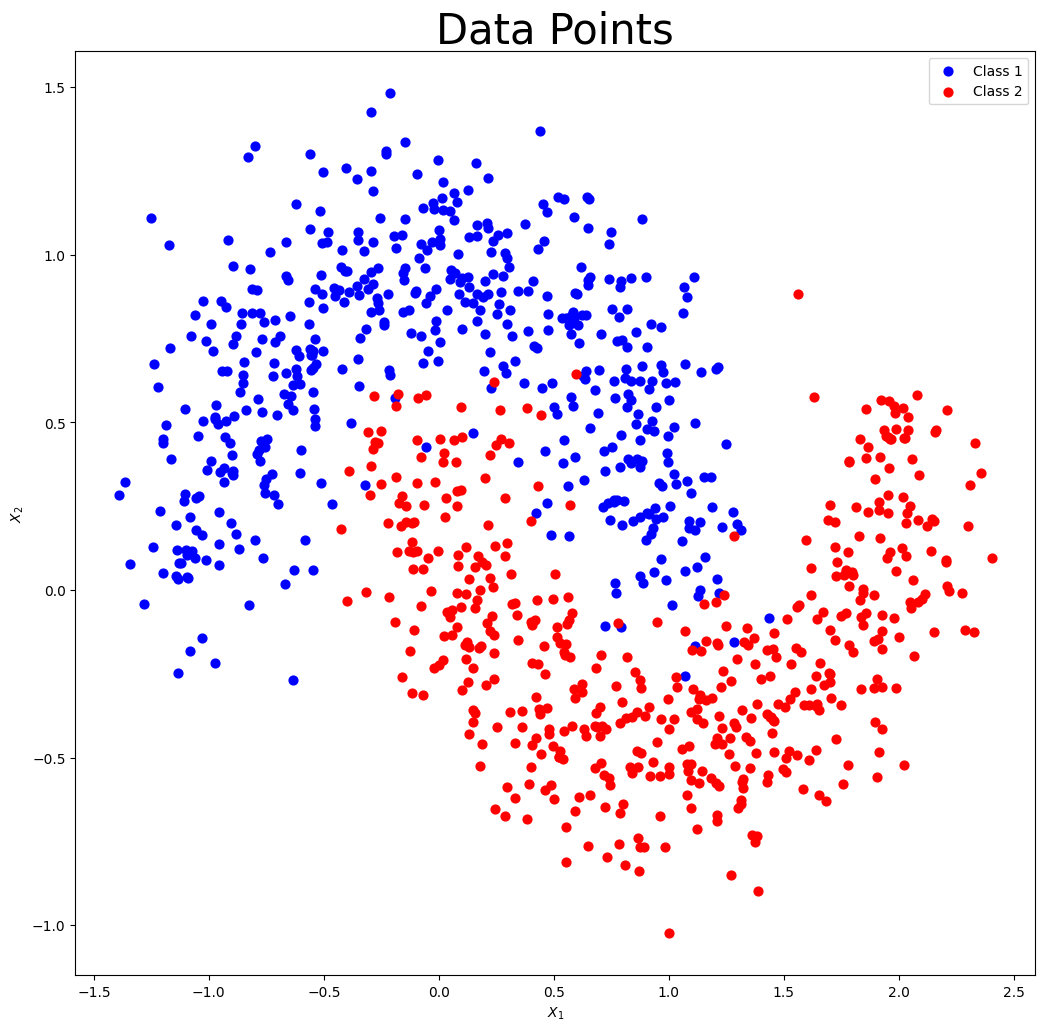

In [1111]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], s=40, c = 'blue', label = 'Class 1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()
make_plot(X, y, 'Data Points')

### (7) Training and Testing the Model [15 points]
- Implement the training loop to optimize your model's parameters over multiple epochs.
- You can experiment with training strategy, e.g., batch size, epochs, learning rate, and model architecture to achieve the best performance.
- Note that you can modify the input shape to fit your implementation.
- Implement a fuction that runs a trained model on test data and returns accuracy.

In [1112]:
model = Model()
loss_fn = BinaryCrossEntropyLoss()
optimizer = Optimizer_SGD(model.parameters())

def train(X, Y, model, loss_fn, optimizer, epochs):
    Y = Y.reshape(-1, 1)

    for epoch in range(epochs):
        forward = model.forward(X)

        loss = loss_fn.forward(forward, Y)

        backward_input = loss_fn.backward(forward, Y)

        model.backward(backward_input)

        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")
    
    return model

def get_test_accuracy(model, X_test, y_test):
    forward = model.forward(X_test)
    pred = (forward >= 0.5)
    return np.mean(pred.astype(int).flatten() == y_test)

In [1113]:
model = train(X, y, model, loss_fn, optimizer, epochs=750)

Epoch 0, Loss: 0.6927021385827709
Epoch 50, Loss: 0.301573478351018
Epoch 100, Loss: 0.29108499691487477
Epoch 150, Loss: 0.28487311488838457
Epoch 200, Loss: 0.2939146265879383
Epoch 250, Loss: 0.2826921101092773
Epoch 300, Loss: 0.26518621206877513
Epoch 350, Loss: 0.23252238432052622
Epoch 400, Loss: 0.181428122420301
Epoch 450, Loss: 0.14359108643278892
Epoch 500, Loss: 0.12427747517365424
Epoch 550, Loss: 0.11274502697056647
Epoch 600, Loss: 0.1052584014649984
Epoch 650, Loss: 0.0991952489112913
Epoch 700, Loss: 0.09536824894462012


In [1114]:
get_test_accuracy(model, X_test, y_test)

np.float64(0.97)

### Visualization: Plot the Decision Boundary

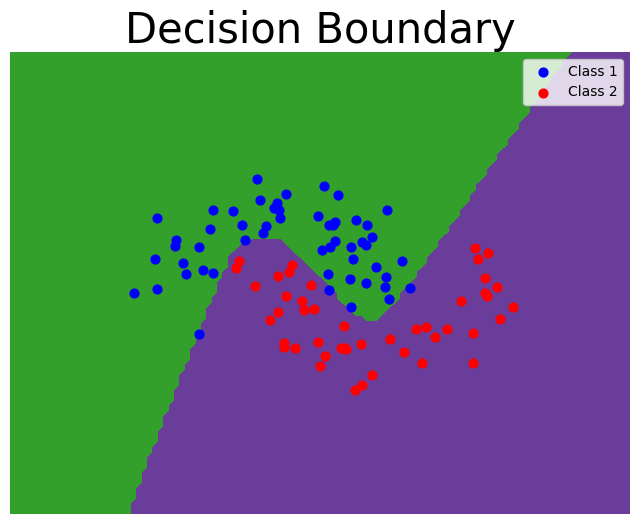

In [1115]:
def plot_decision_boundary(model, X_train, Y_train, X_test, Y_test):
    # function to draw the model's decision boundary
    h = 0.05
    X = np.concatenate([X_train, X_test], axis = 0)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    input = np.stack([xx,yy], axis = -1).reshape(-1,2)
    pred = model.forward(input)
    index = pred >= 0.5
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.title('Decision Boundary', fontsize=30)
    ax.contourf(xx, yy, index.reshape(xx.shape), cmap=plt.cm.Paired)
    ax.axis('off')
    ax.scatter(X_test[Y_test == 0,0], X_test[Y_test == 0,1], s = 40,  c = 'blue', label = 'Class 1')
    ax.scatter(X_test[Y_test == 1,0], X_test[Y_test == 1,1], s = 40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()

plot_decision_boundary(model, X_train, y_train, X_test, y_test)